In [4]:
!pip install -r requirements.txt
!pip install daal==2021.4.0
!pip install clyent==1.2.1
!pip install opacus --user

  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached aiobotocore-2.1.2-py3-none-any.whl
  Using cached aiohttp-3.8.3-cp38-cp38-win_amd64.whl (324 kB)
  Using cached aioitertools-0.10.0-py3-none-any.whl (23 kB)
  Using cached aiosignal-1.2.0-py3-none-any.whl (8.2 kB)
  Using cached alembic-1.8.1-py3-none-any.whl (209 kB)
  Using cached anyio-3.6.1-py3-none-any.whl (80 kB)
  Using cached apache-log-parser-1.7.0.tar.gz (7.9 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached asgiref-3.5.2-py3-none-any.whl (22 kB)
  Using cached astroid-2.4.2-py3-none-any.whl (213 kB)
  Using cached asttokens-2.0.8-py2.py3-none-any.whl (23 kB)
  Using cached attrs-22.1.0-py2.py3-none-any.whl (58 kB)
  Using cached azure_common-1.1.27-py2.py3-none-any.whl (12 kB)
  Using cached azure_core-1.19.0-py2.py3-none-any.whl (176 kB)
  Using cached azure_functions-1.7.2-py3-none-any.whl (137 kB)
  Using cached azure_identity-1.6.1-

ERROR: Cannot install functorch==2.0.0 and torch==1.13.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [2]:
#!pip install virtualenv
#!virtualenv lightning
#!python -m ipykernel install --user --name=lightning

created virtual environment CPython3.8.2.final.0-64 in 13703ms
  creator CPython3Windows(dest=C:\Users\Franz Schramm\source\repos\MasterThesis\lightning, clear=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=C:\Users\Franz Schramm\AppData\Local\pypa\virtualenv)
    added seed packages: pip==20.2.2, pip==23.0.1, setuptools==49.6.0, setuptools==67.5.1, wheel==0.35.1, wheel==0.40.0
  activators BashActivator,BatchActivator,FishActivator,PowerShellActivator,PythonActivator,XonshActivator


In [4]:
!python -m ipykernel install --user --name=lightning

Installed kernelspec lightning in C:\Users\Franz Schramm\AppData\Roaming\jupyter\kernels\lightning


In [3]:
!cd C:\Users\Franz Schramm\source\repos\MasterThesis
!python -m pip install --upgrade pip

     ---------------------------------------- 2.1/2.1 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [34]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

#os.chdir("../../..")

In [5]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

OSError: [WinError 127] Die angegebene Prozedur wurde nicht gefunden

In [36]:
from pytorch_forecasting.data.examples import get_stallion_data
import numpy as np
data = get_stallion_data()  # load data as pandas dataframe


# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()
# add additional features
# categories have to be strings
data["month"] = data.date.dt.month.astype(str).astype("category")
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = (
    data
    .groupby(["time_idx", "sku"], observed=True)
    .volume.transform("mean")
)
data["avg_volume_by_agency"] = (
    data
    .groupby(["time_idx", "agency"], observed=True)
    .volume.transform("mean")
)
# we want to encode special days as one variable and 
# thus need to first reverse one-hot encoding
special_days = [
    "easter_day", "good_friday", "new_year", "christmas",
    "labor_day", "independence_day", "revolution_day_memorial",
    "regional_games", "fifa_u_17_world_cup", "football_gold_cup",
    "beer_capital", "music_fest"
]
data[special_days] = (
    data[special_days]
    .apply(lambda x: x.map({0: "-", 1: x.name}))
    .astype("category")
)


In [37]:
# show sample data
data.sample(10, random_state=521)


,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [38]:
data.describe()

,volume,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
std,2711.496882,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698
min,0.000000,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375


In [39]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [40]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


In [41]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at C:\Users\Franz Schramm\.lr_find_27d06f51-9201-49b2-aa45-ec23be8eb1b5.ckpt


suggested learning rate: 0.01862087136662867


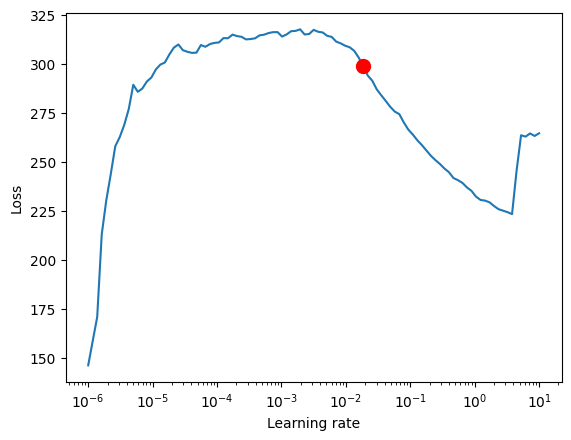

In [44]:
fig = res.plot(show=True, suggest=True)
fig.show()

In [45]:
!cd

C:\Users\Franz Schramm


In [46]:

from pytorch_forecasting import (
    TimeSeriesDataSet,
    GroupNormalizer
)
max_prediction_length = 6  # forecast 6 months
max_encoder_length = 24  # use 24 months of history
training_cutoff = data["time_idx"].max() - max_prediction_length
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=0,  # allow predictions without history
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=[
        "avg_population_2017",
        "avg_yearly_household_income_2017"
    ],
    time_varying_known_categoricals=["special_days", "month"],
    # group of categorical variables can be treated as 
    # one variable
    variable_groups={"special_days": special_days},
    time_varying_known_reals=[
        "time_idx",
        "price_regular",
        "discount_in_percent"
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"]#, coerce_positive=1.0
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,  # add as feature
    add_target_scales=True,  # add as feature
    add_encoder_length=True,  # add as feature
)
# create validation set (predict=True) which means to predict the
# last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)
# create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0 # set to 8 for current machine
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0 # set to 8 for current machine
)



In [47]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    #LearningRateLogger
)
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models import TemporalFusionTransformer
# stop training, when loss metric does not improve on validation set
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode="min"
)
#lr_logger = LearningRateLogger()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # log to tensorboard
# create trainer
trainer = pl.Trainer(
    max_epochs=50,
    accelerator='cpu',
    #devices=8,
    #gpus=0,  # train on CPU, use gpus = [0] to run on GPU -- deprecated
    gradient_clip_val=0.1,
    #early_stop_callback=early_stop_callback,
    limit_train_batches=50,  # running validation every 30 batches
    # fast_dev_run=True,  # comment in to quickly check for bugs
    #callbacks=[lr_logger],
    logger=logger,
)
# initialise model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,  # biggest influence network size
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # QuantileLoss has 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # log example every 10 batches
    reduce_on_plateau_patience=4,  # reduce learning automatically
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


In [48]:
tft.size() # 29.6k parameters in model
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [13]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test", 
    n_trials=100,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-03-29 11:01:46,196] A new study created in memory with name: no-name-cd38430c-20e8-4ad3-ab41-3b6a4e457f2d
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-03-29 11:18:20,712] Trial 0 finished with value: 156.2430877685547 and parameters: {'gradient_clip_val': 0.22090411288367834, 'hidden_size': 47, 'dropout': 0.16368567468578615, 'hidden_continuous_size': 47, 'attention_head_size': 1, 'learning_rate': 0.012971531551767045}. Best is trial 0 with value: 156.2430877685547.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-03-29 11:30:44,352] Trial 1 finished with value: 172.21376037597656 and parameters: {'gradient_clip_val': 0.3353974504289621, 'hidden_size': 19, 'dropout': 0.23

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-03-29 12:09:54,600] Trial 31 finished with value: 162.93646240234375 and parameters: {'gradient_clip_val': 0.0670266727506334, 'hidden_size': 32, 'dropout': 0.2947434082693505, 'hidden_continuous_size': 13, 'attention_head_size': 4, 'learning_rate': 0.06985837443782911}. Best is trial 0 with value: 156.2430877685547.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-03-29 12:10:23,921] Trial 32 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-03-29 12:11:39,319] Trial 33 pruned. Trial was pruned at epoch 4.
GPU available: False, used: False
TP

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-03-29 13:07:00,514] Trial 65 pruned. Trial was pruned at epoch 4.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-03-29 13:07:36,249] Trial 66 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-03-29 13:08:04,616] Trial 67 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-03-29 13:08:35,270] Trial 68 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU a

{'gradient_clip_val': 0.22090411288367834, 'hidden_size': 47, 'dropout': 0.16368567468578615, 'hidden_continuous_size': 47, 'attention_head_size': 1, 'learning_rate': 0.012971531551767045}


In [50]:
from pytorch_forecasting.metrics import MAE
import torch
# load the best model according to the validation loss (given that
# we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


lightning_logs\lightning_logs\version_2\checkpoints\epoch=49-step=2500.ckpt


In [87]:
# calculate mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(258.5601)

In [101]:
import opacus
privacy_engine = opacus.privacy_engine.PrivacyEngine()
model = best_tft
optimizer = torch.optim.SGD(best_tft.parameters(), lr=0.05)
dataloader = val_dataloader
model, optimizer, dataloader = privacy_engine.make_private(module=model, optimizer=optimizer, data_loader=dataloader, noise_multiplier=1.0, max_grad_norm=1.0)

UnsupportedModuleError: [IllegalModuleConfigurationError('Model needs to be in training mode')]

TypeError: 'list' object is not callable

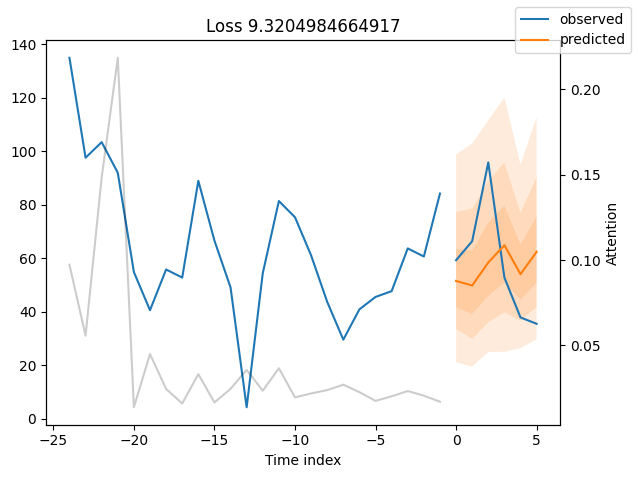

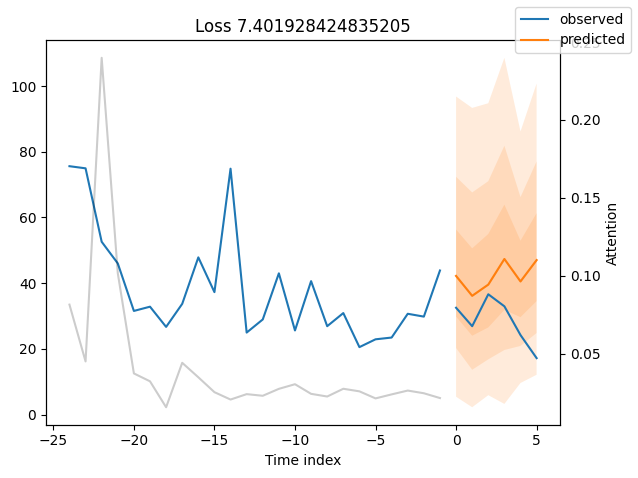

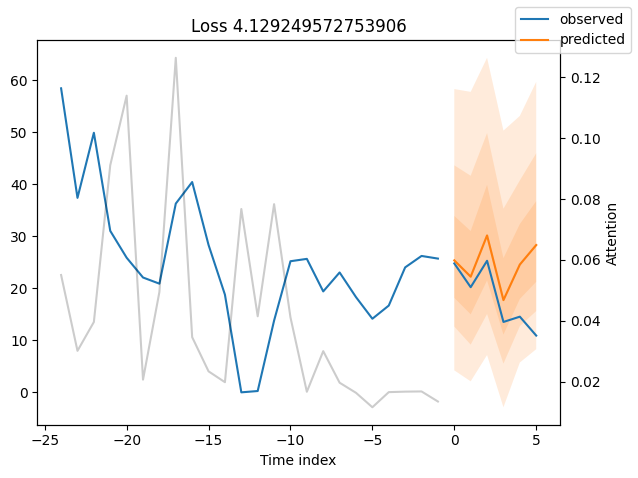

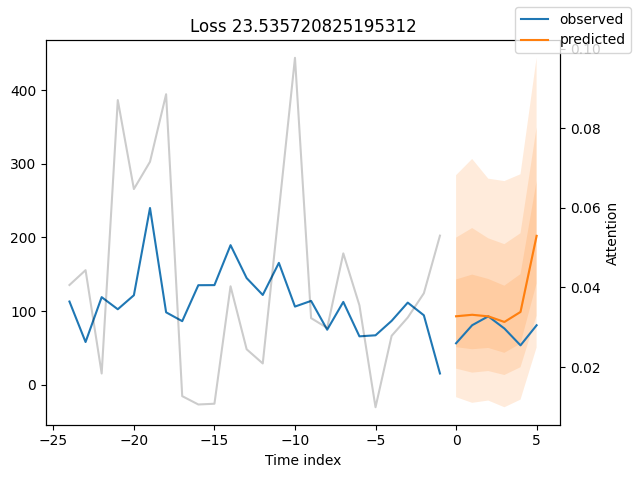

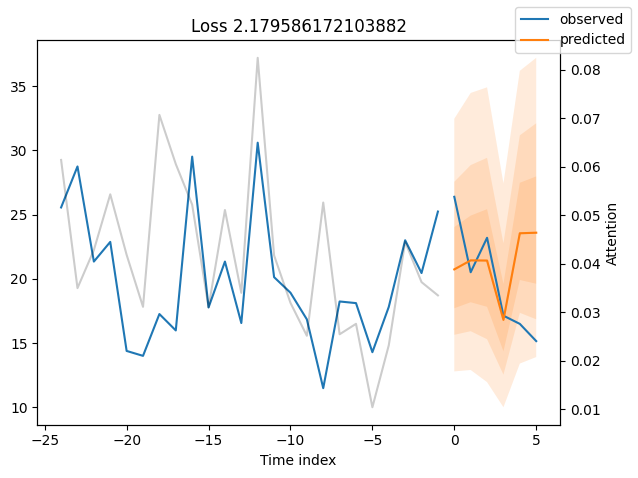

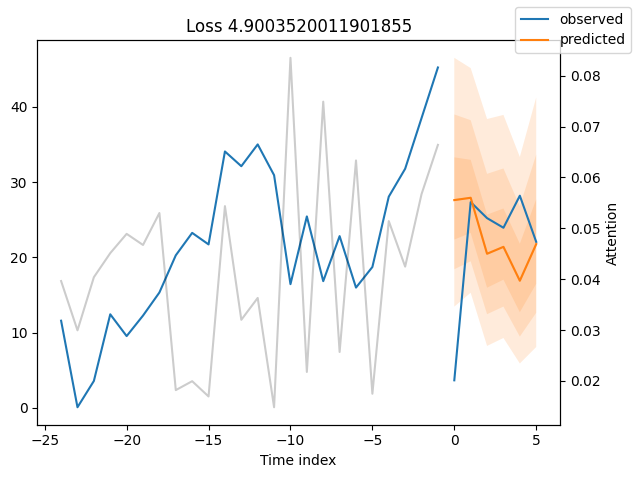

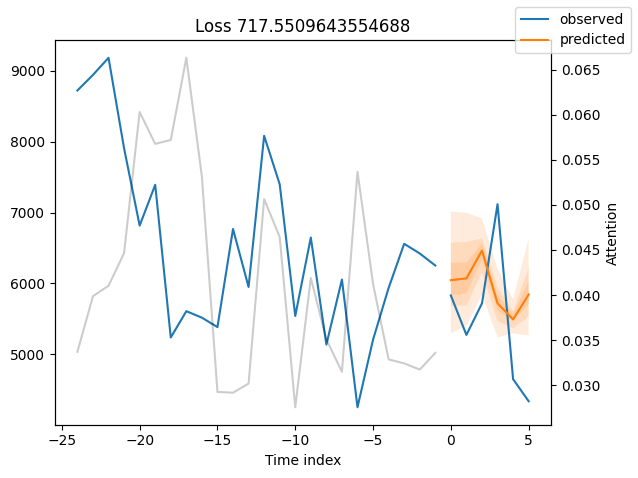

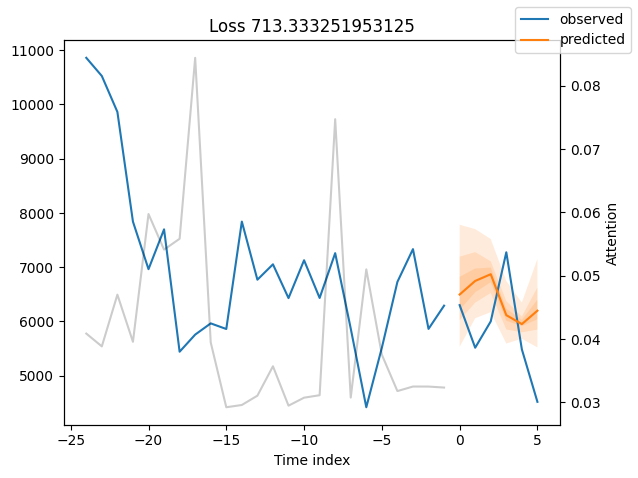

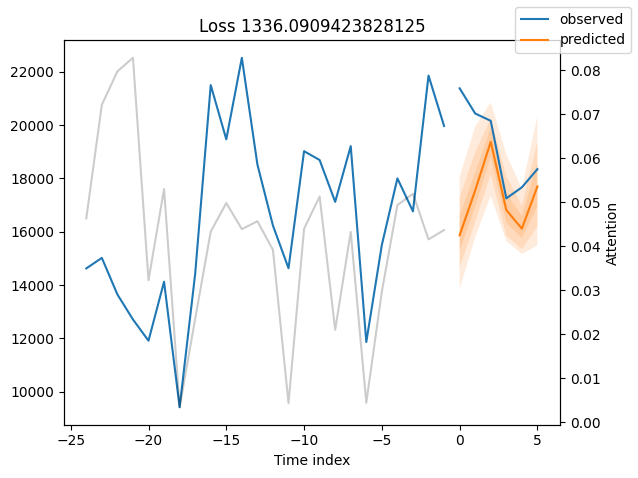

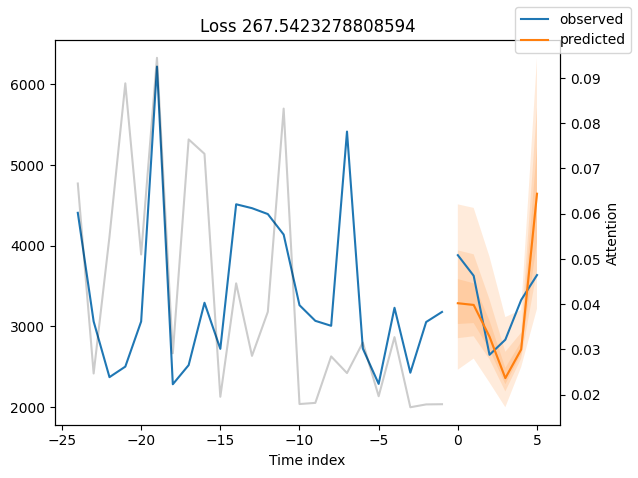

In [105]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    filename = "C:/Users/Franz Schramm/source/repos/MasterThesis/results/Predictions/Raw_Predictions/raw_prediction{}".format(idx)
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True).savefig(filename)

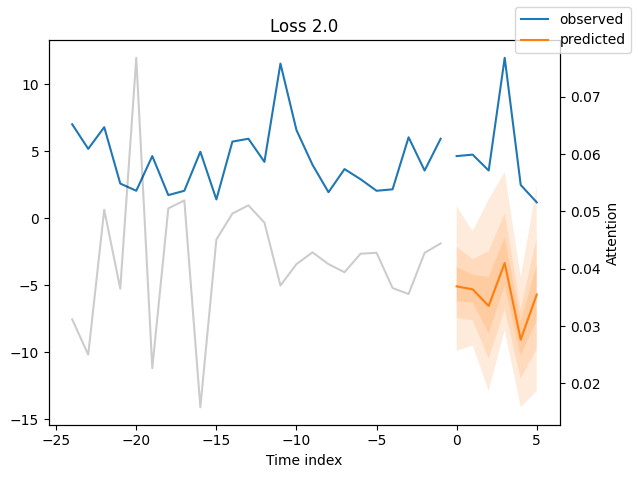

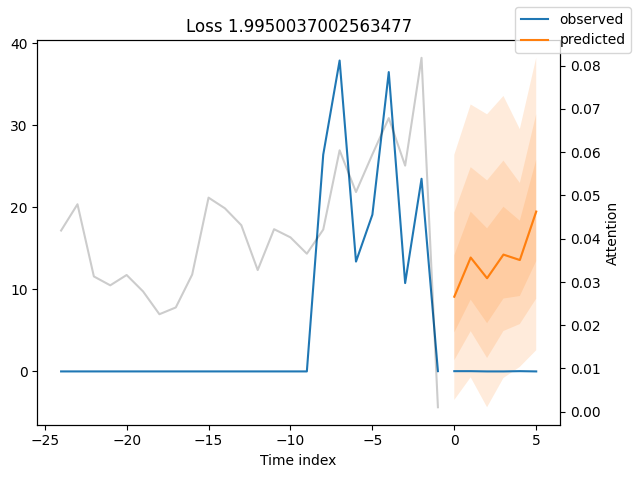

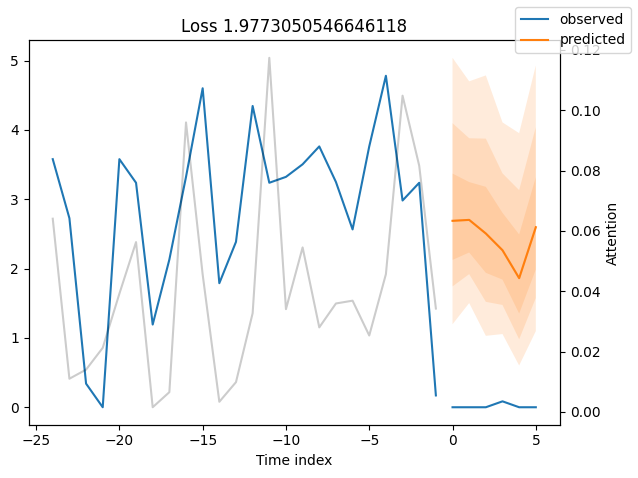

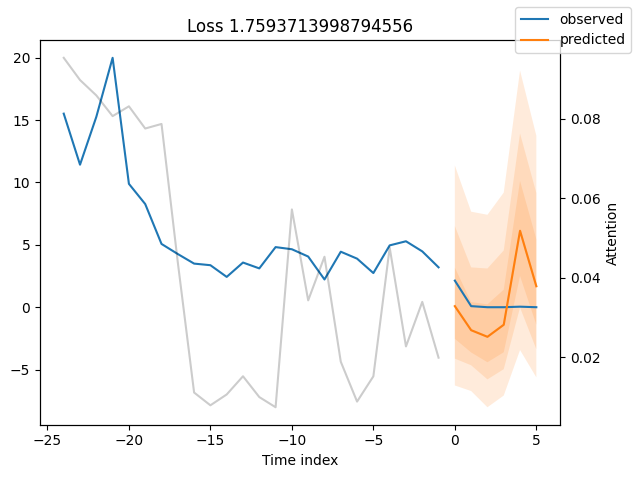

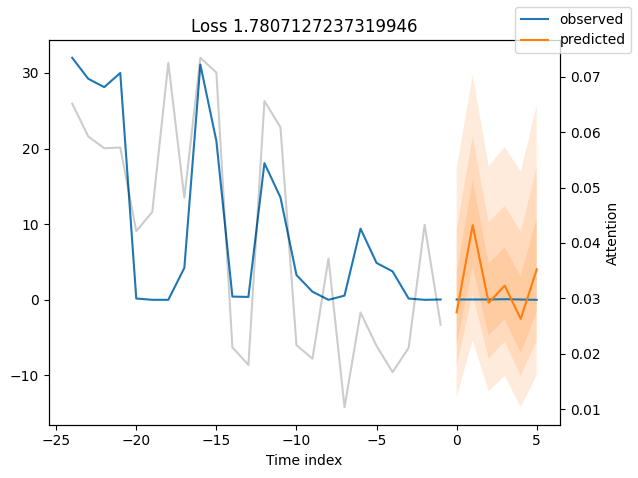

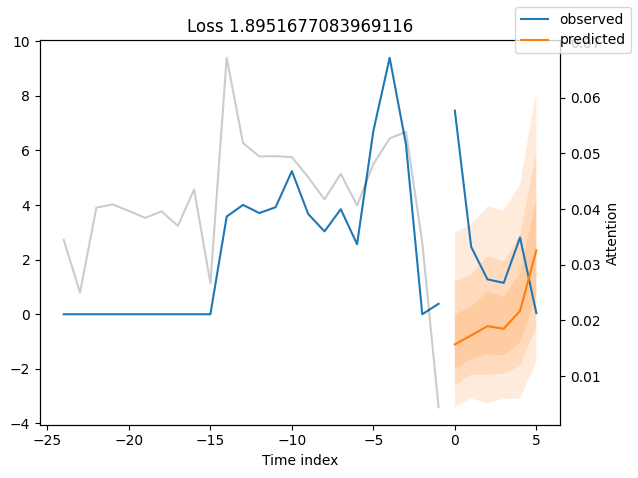

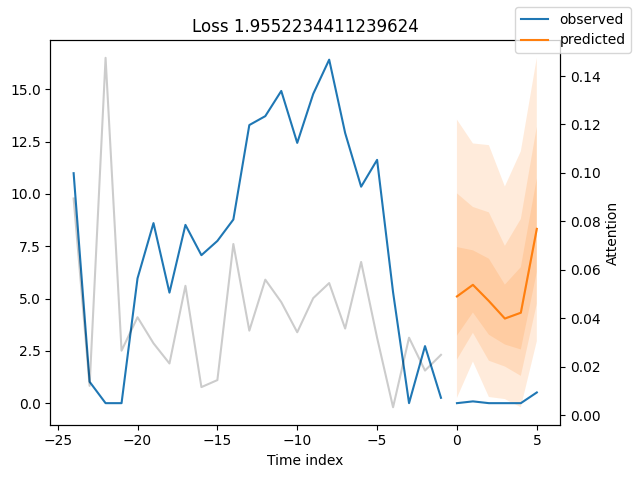

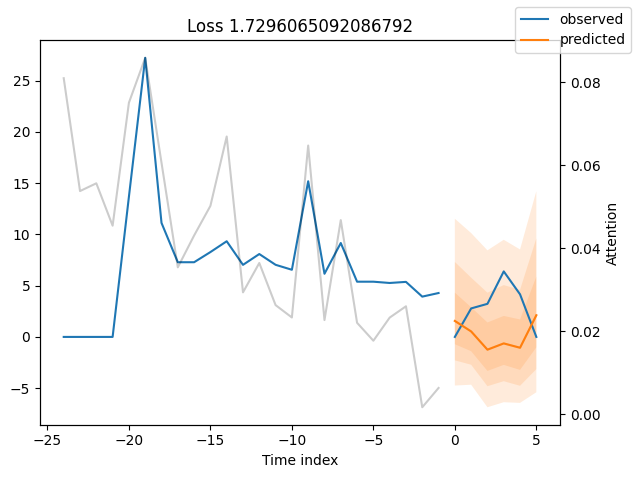

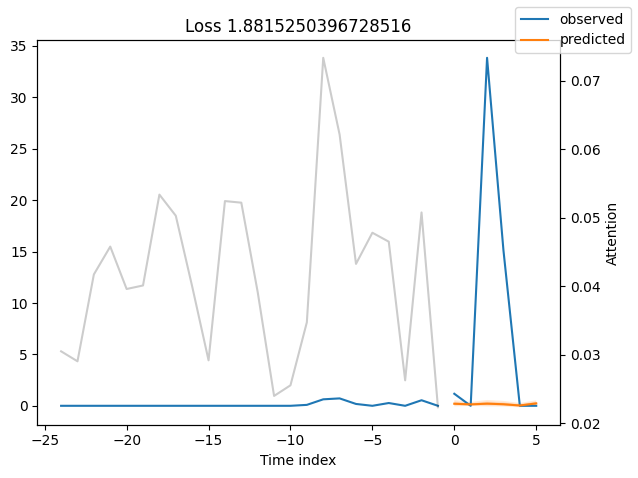

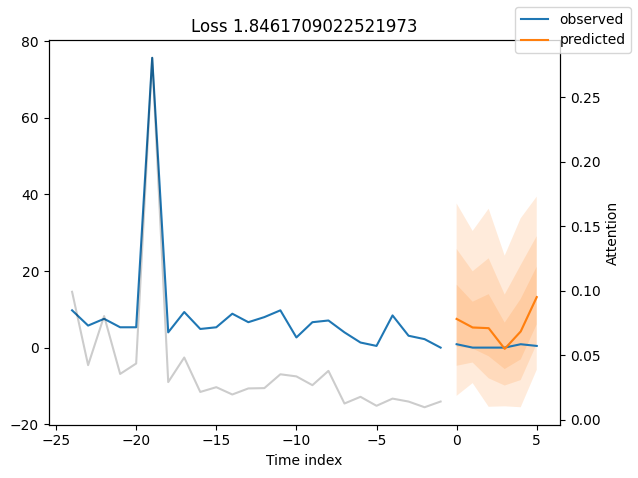

In [108]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    filename = "C:/Users/Franz Schramm/source/repos/MasterThesis/results/Predictions/Quantile_Loss_SMAPE/best_quantile{}".format(idx)
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    ).savefig(filename);

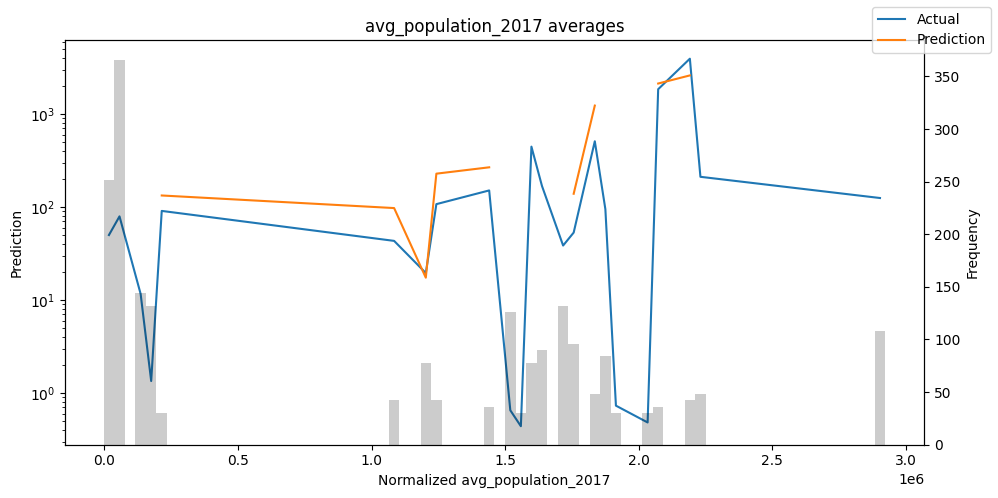

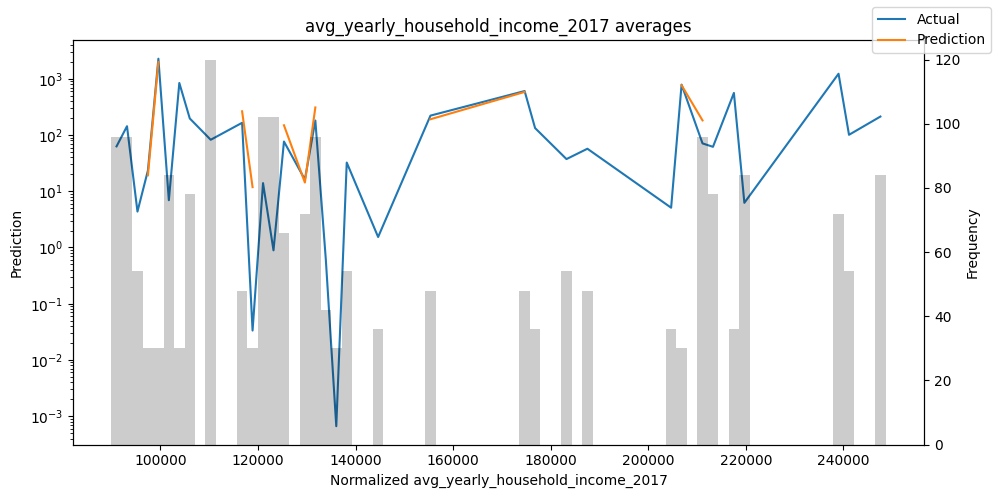

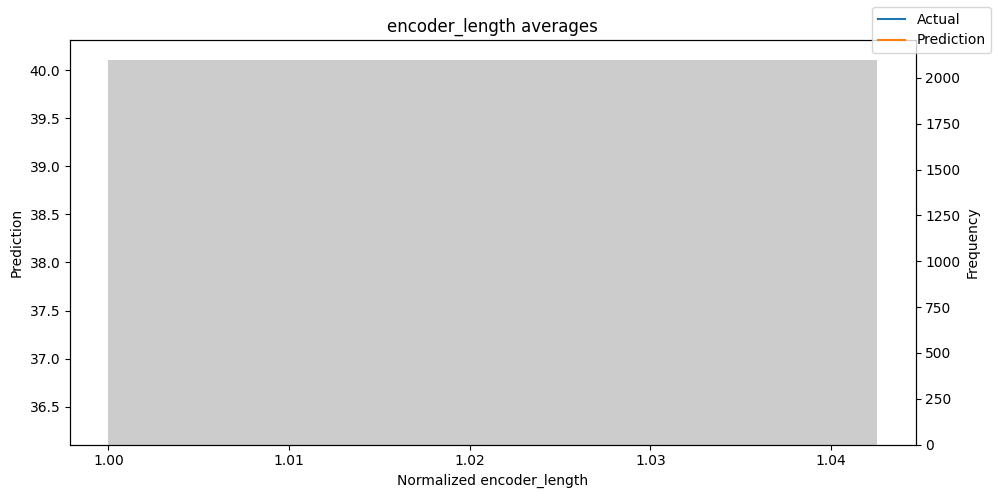

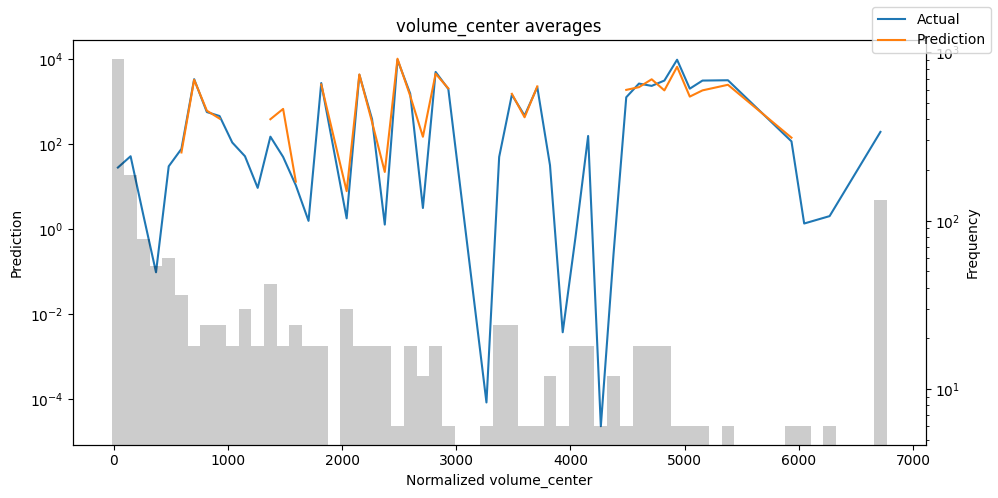

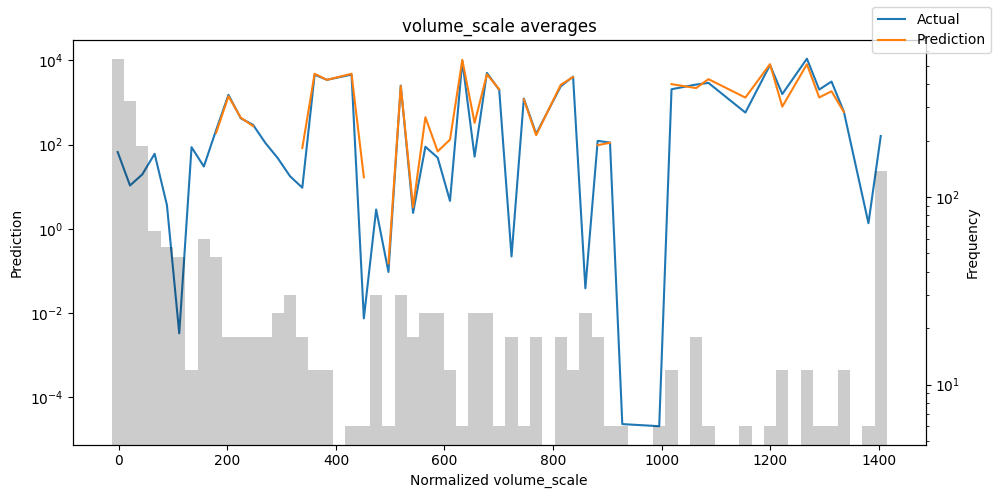

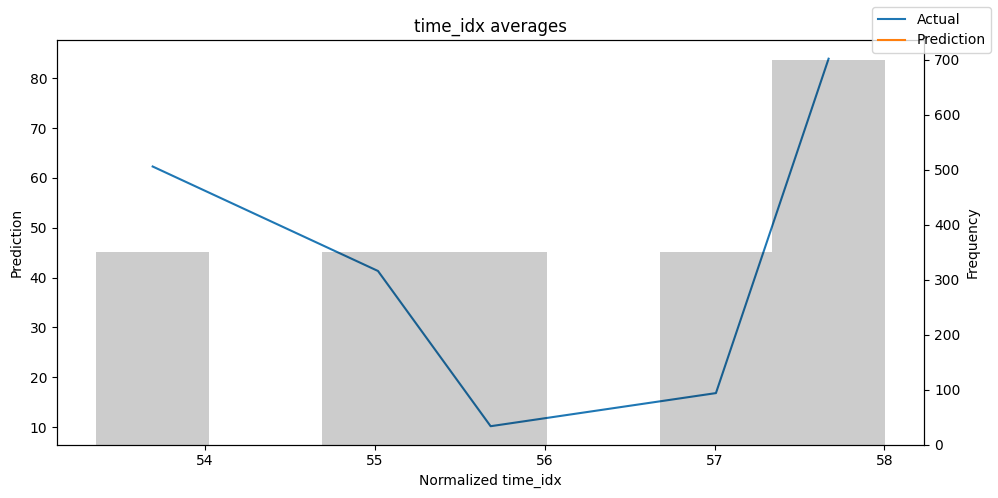

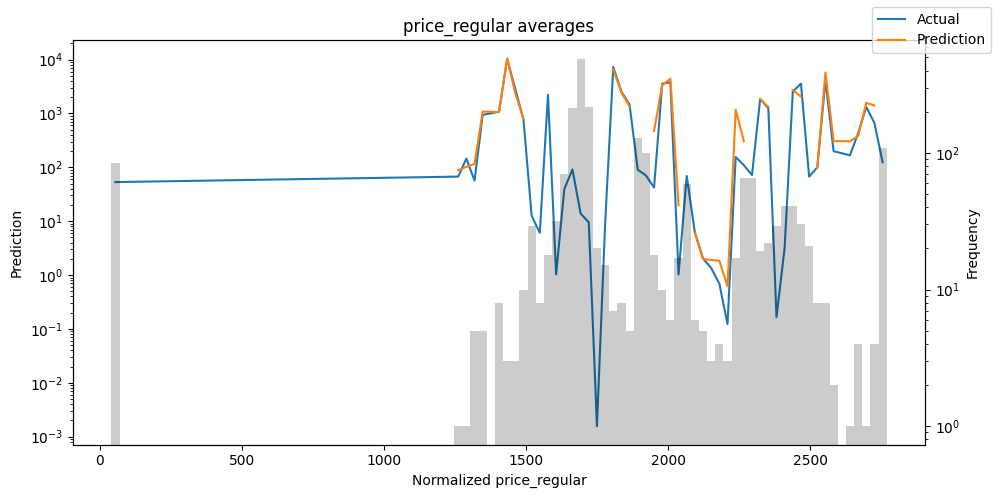

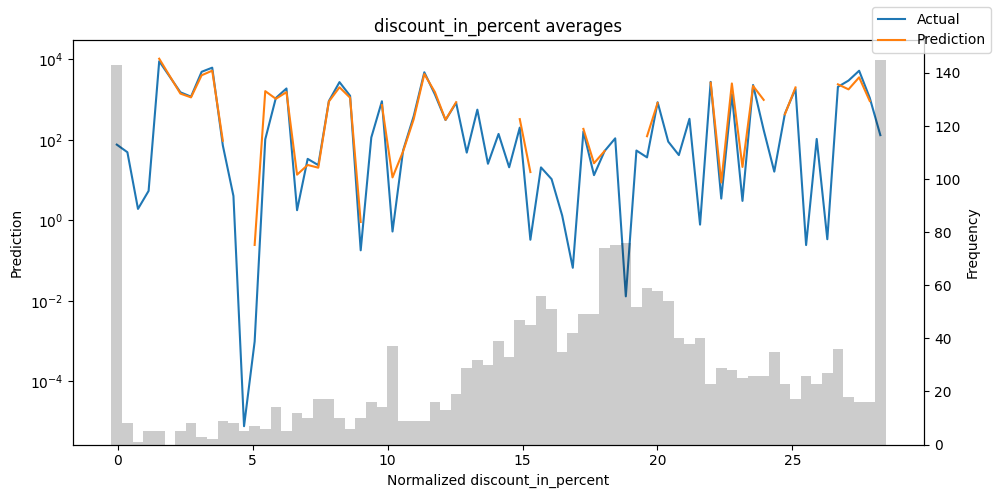

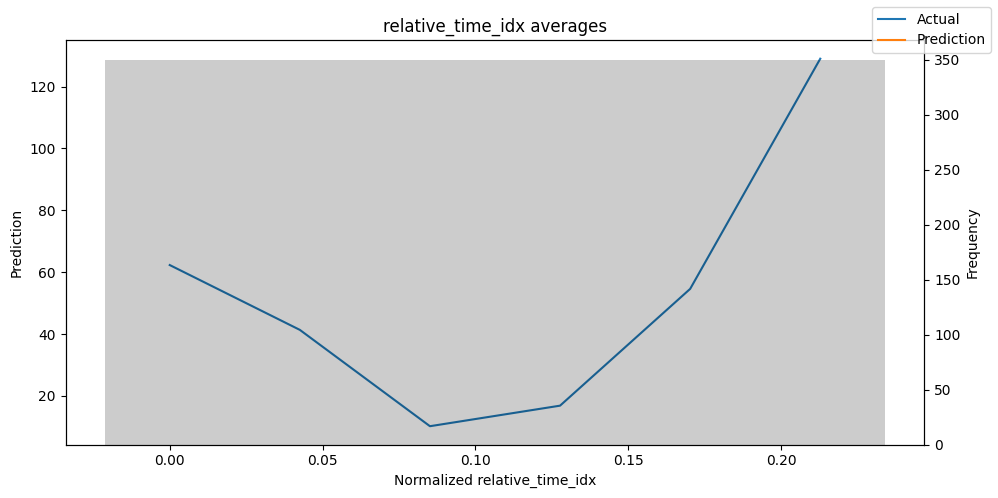

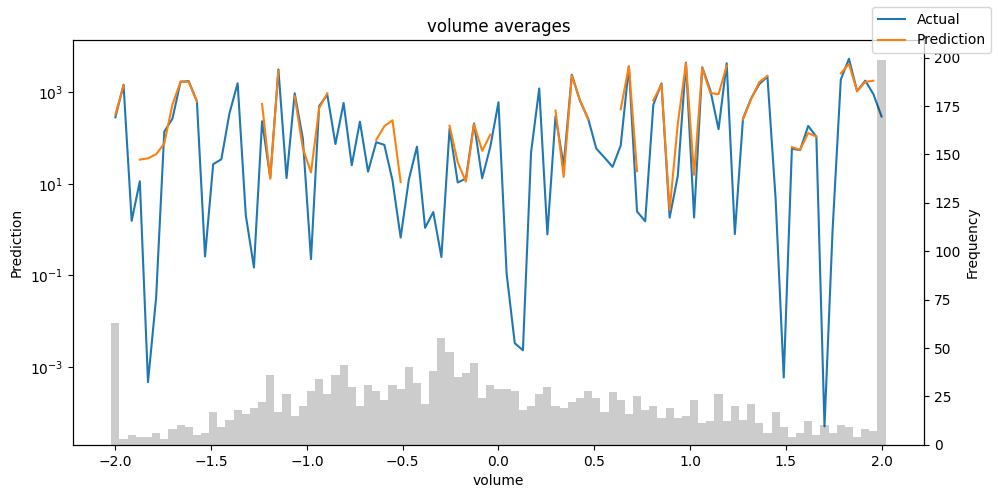

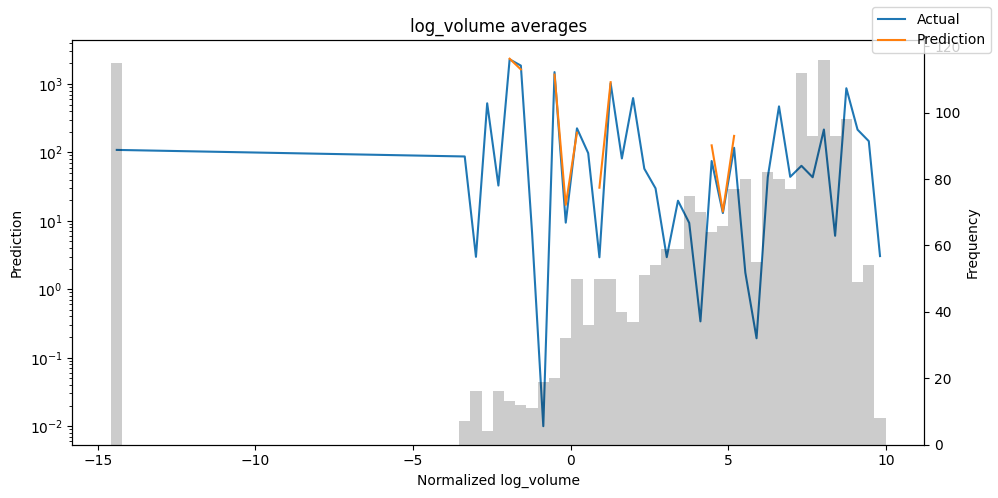

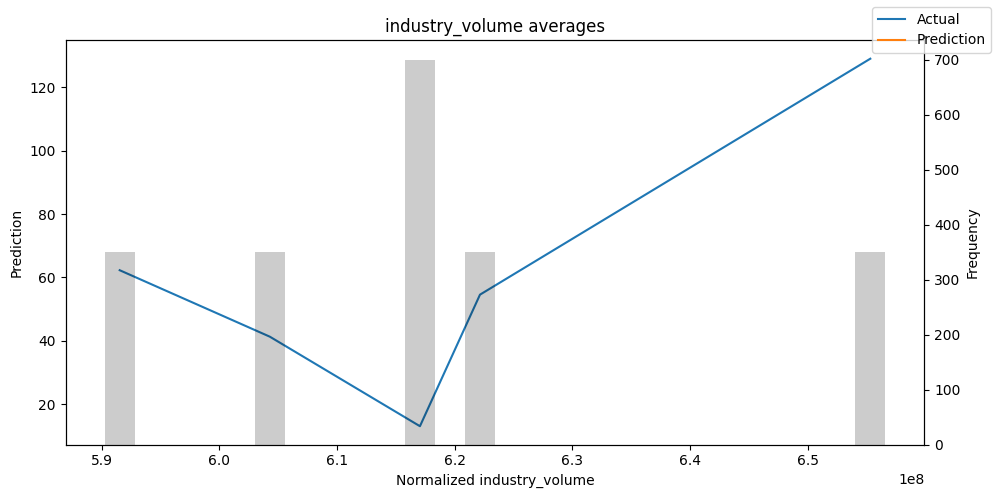

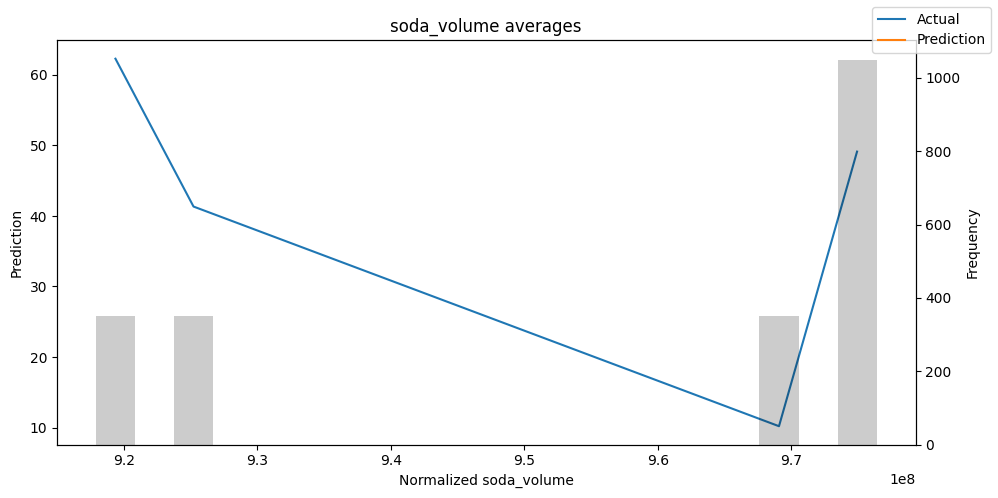

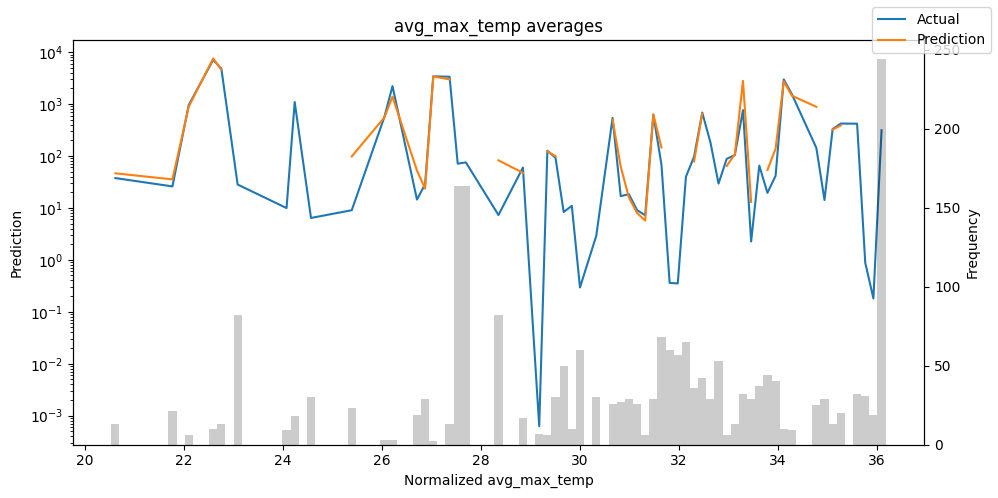

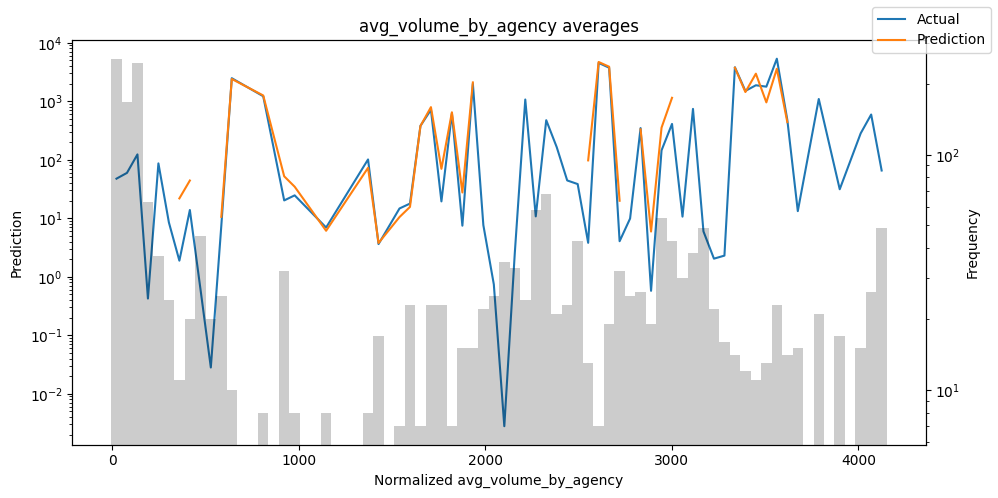

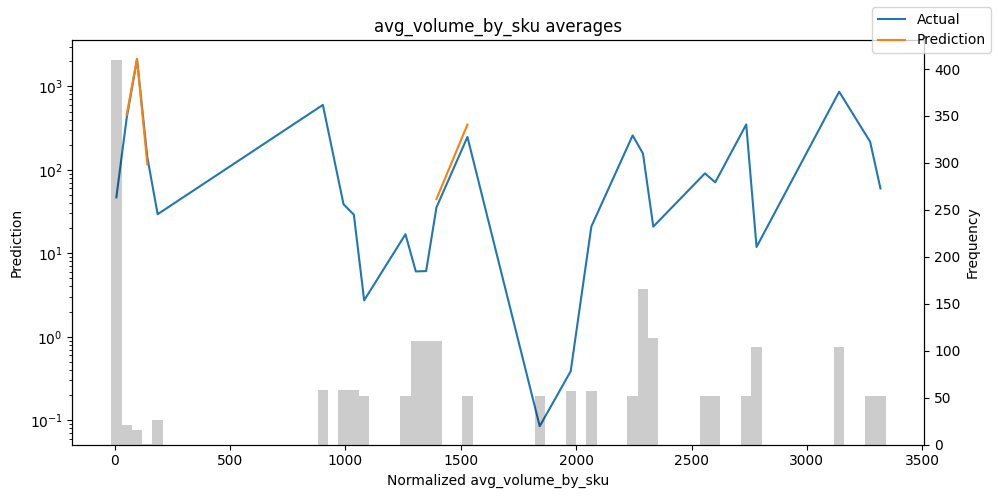

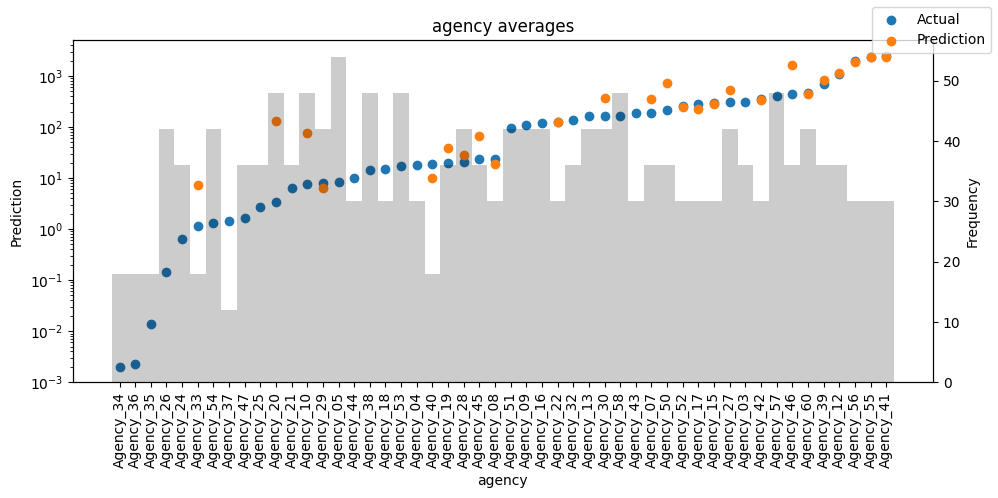

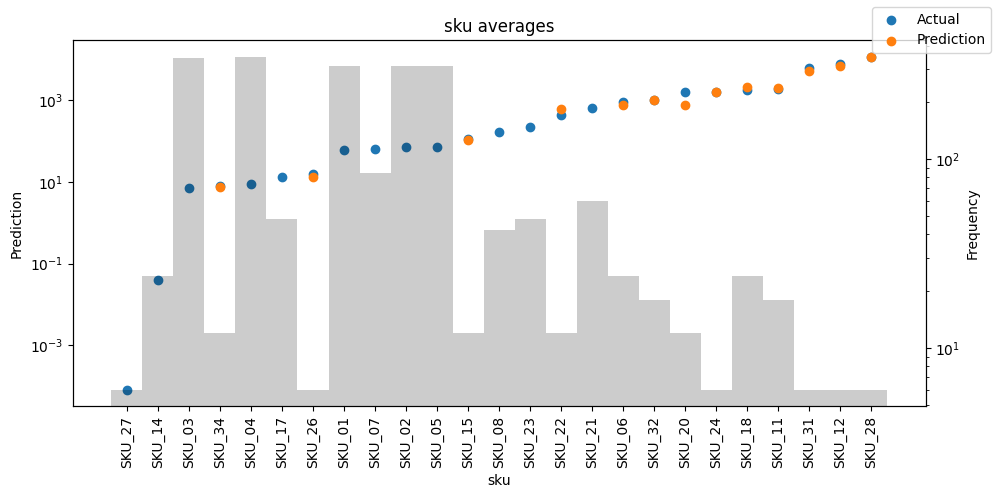

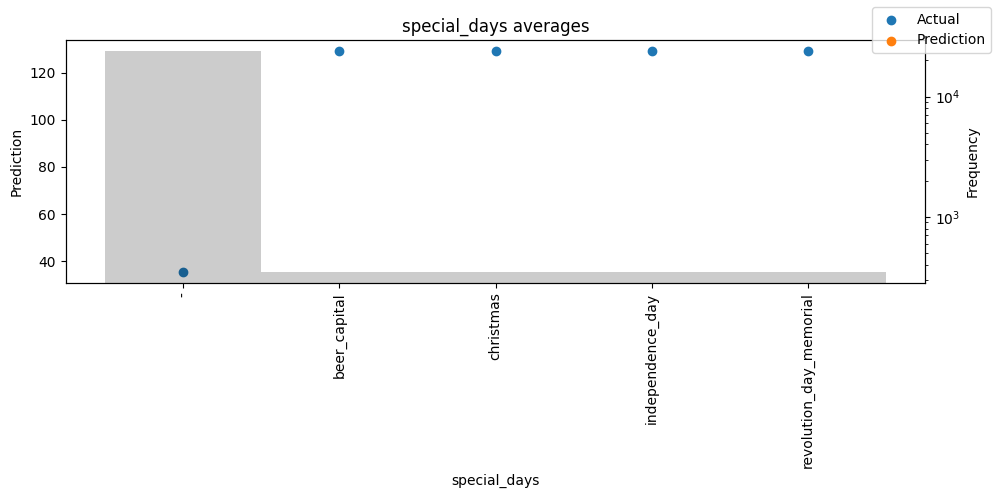

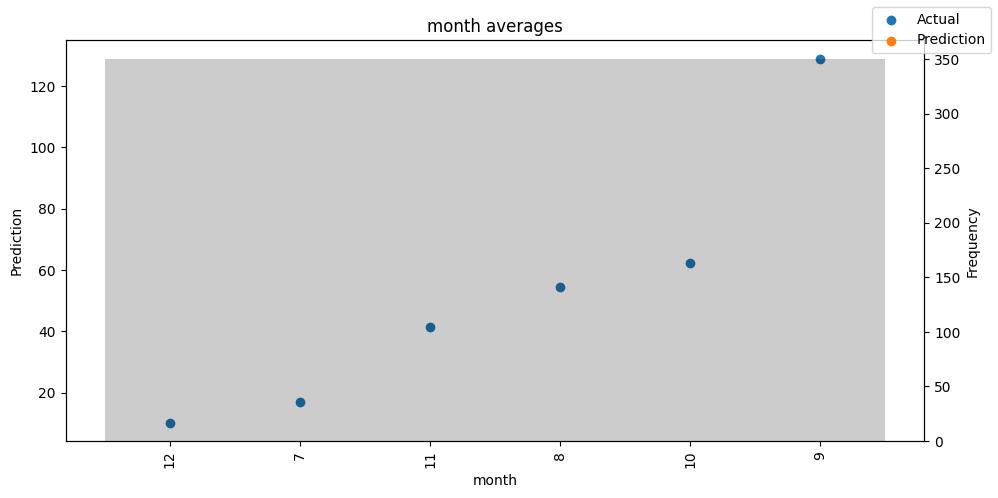

In [114]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
filename = "C:/Users/Franz Schramm/source/repos/MasterThesis/results/Predictions/PredvsActual/result{}"
y = best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);
for x in y:
    y[x].savefig(filename.format(x))

In [74]:
best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

tensor([[[ 73.0066,  94.8453, 111.9147, 131.0195, 150.7215, 172.4638, 202.0838],
         [ 63.3801,  87.4013, 104.1921, 123.5355, 144.2909, 166.0427, 194.8800],
         [ 54.5096,  73.9959,  88.9080, 105.4630, 123.6876, 142.4478, 167.0409],
         [ 54.3079,  71.3179,  85.5237, 102.2653, 121.2594, 141.6863, 168.1345],
         [ 64.1161,  77.8979,  90.5013, 105.3882, 121.7161, 140.6805, 165.3623],
         [ 37.0451,  55.6454,  68.4961,  83.4658, 100.4576, 119.0917, 144.5625]]])

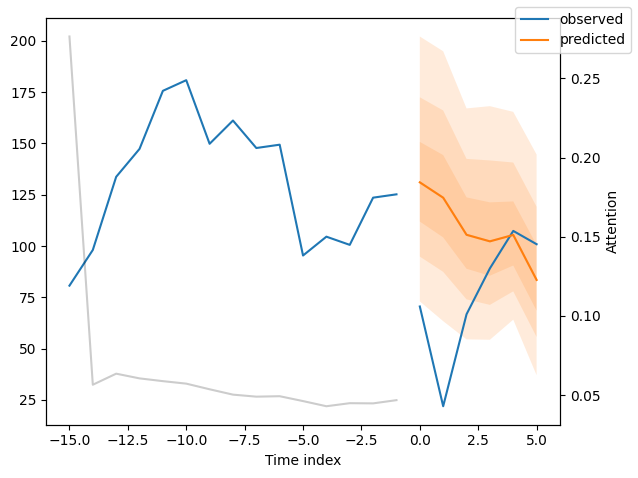

In [115]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0).savefig("C:/Users/Franz Schramm/source/repos/MasterThesis/results/Predictions/Ag1SKU1");

In [76]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

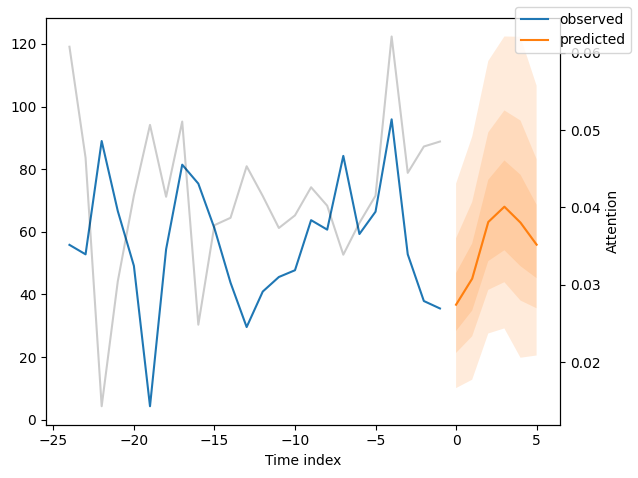

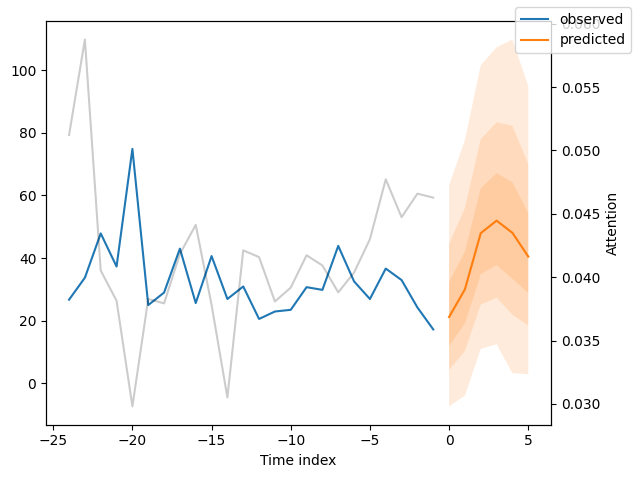

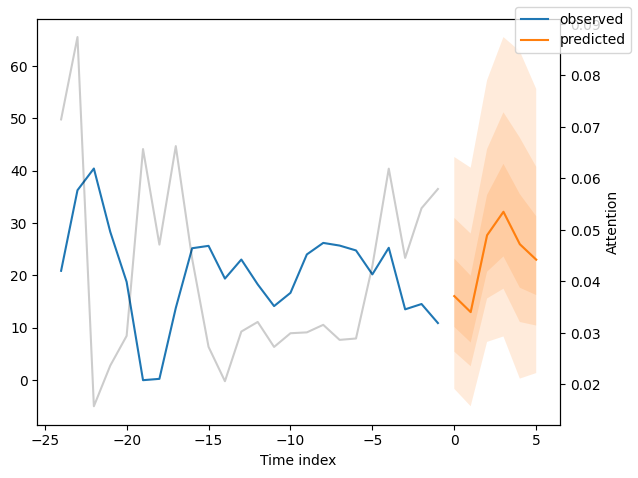

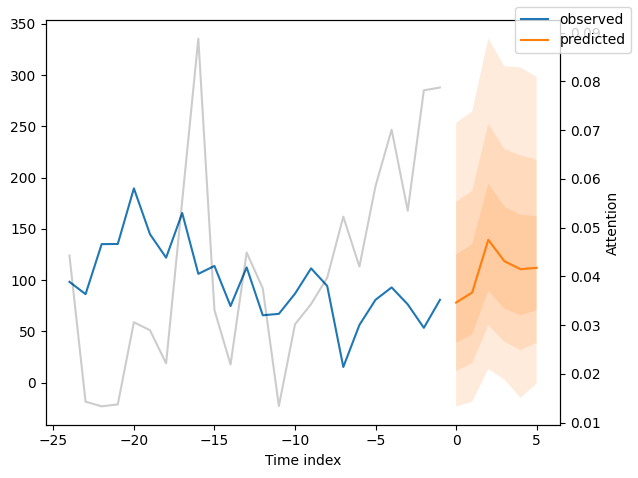

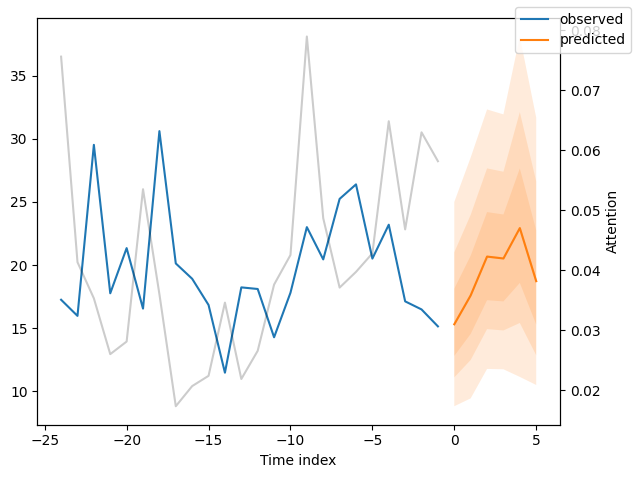

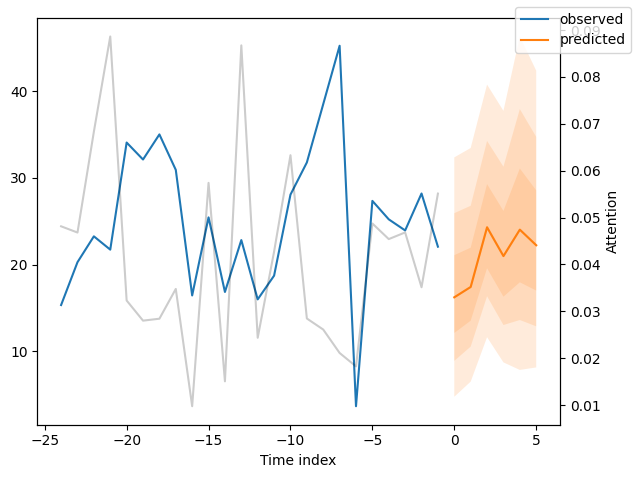

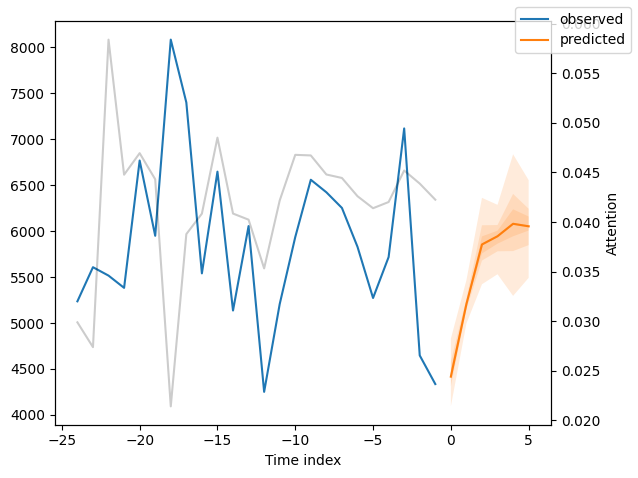

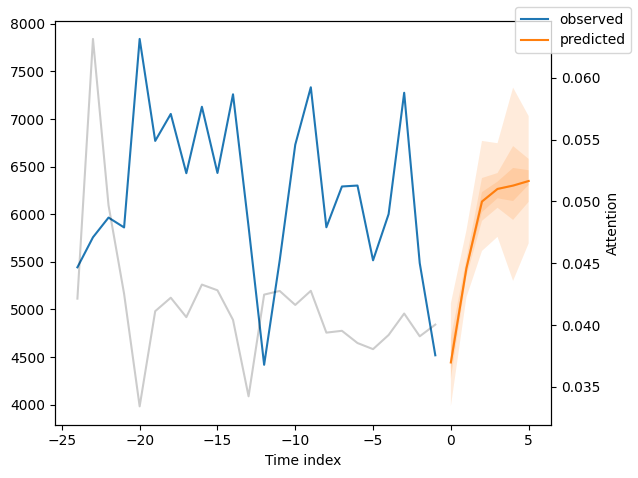

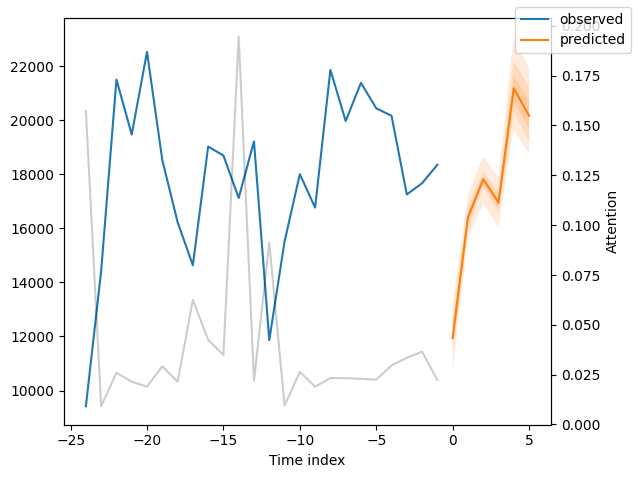

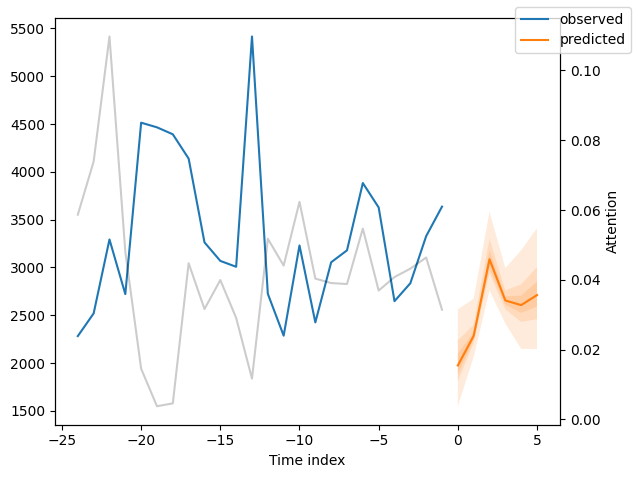

In [77]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

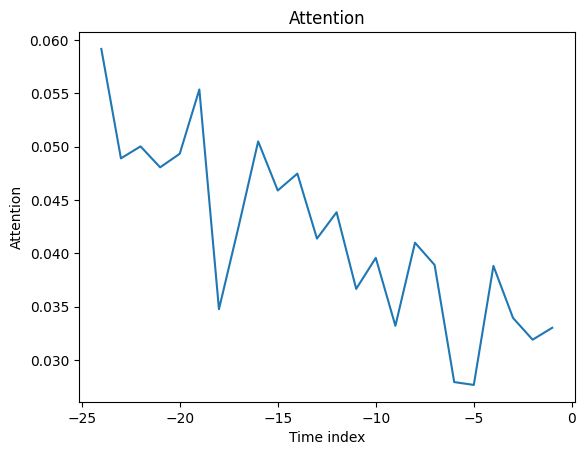

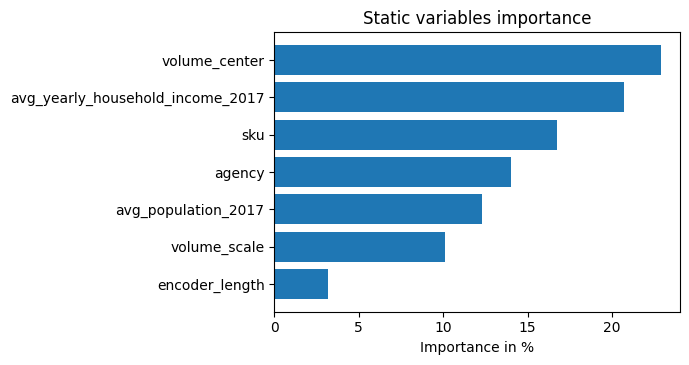

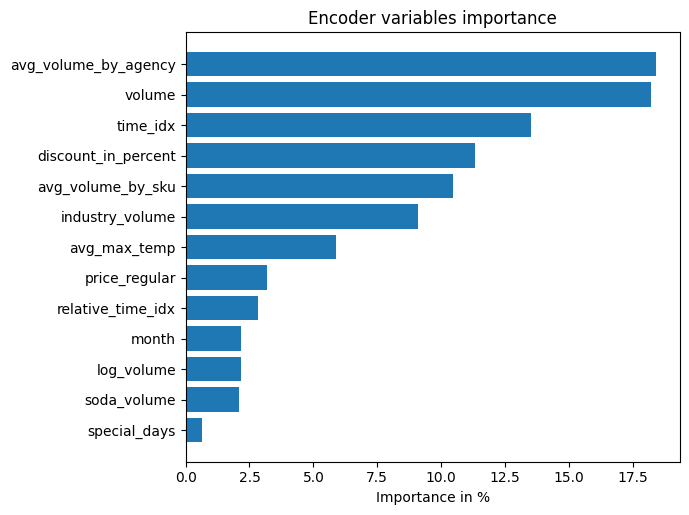

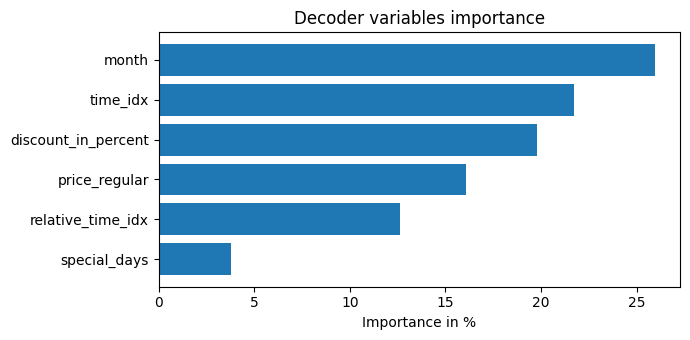

In [118]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
y = best_tft.plot_interpretation(interpretation)
filename = "C:/Users/Franz Schramm/source/repos/MasterThesis/results/Predictions/Interpretations/{}"
for x in y:
    y[x].savefig(filename.format(x))

In [79]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

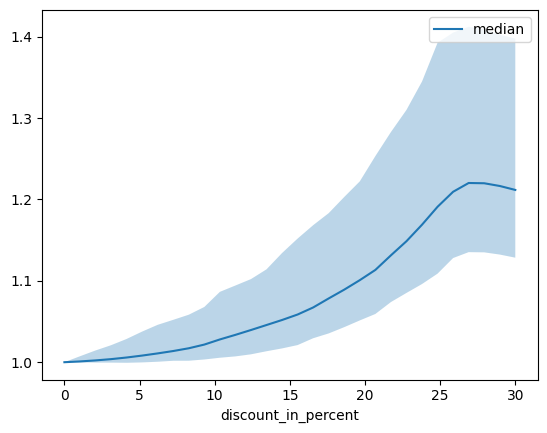

In [119]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);
fig = ax.get_figure()
fig.savefig("MedianAnd25_75")